DECIMER Workflow
==========================

This script implements a workflow for processing PDF publications to extract chemical structures,
predict SMILES (Simplified Molecular Input Line Entry System) representations with confidence scores,
and generate comprehensive output reports.

The script performs the following steps:
1. Parsing command-line arguments to specify input files or directories.
2. Image segmentation of PDF pages to isolate chemical structure images.
3. Prediction of SMILES representations with confidence scores for segmented images.
4. Creation of CSV files containing SMILES and confidence data for each segmented image.
5. Concatenation and analysis of CSV files to categorize chemical structures based on confidence scores.
6. Identification of parsing errors and generation of detailed output reports (PDFs) with segmented images
   and associated SMILES predictions or error messages.
7. Merging of output PDFs into comprehensive reports for each processed publication.

Command-line Usage:
- Use `-f` to specify a single PDF file for processing.
- Use `-folder` to specify a directory containing multiple PDF files for batch processing.
- Optionally, use `-c` to set a confidence threshold for splitting SMILES predictions.

Example:

```$ python3 decimer_workflow.py -folder path/to/directory/with/publications -c desired_confidence_value_to_split &> path/to/directory/with/publications/out.txt 2>&1```


Dependencies:
- Python 3.x
- DECIMER (https://decimer.ai/)
- PDF2Image (https://github.com/Belval/pdf2image)
- RDKit (https://github.com/rdkit/rdkit)
- FPDF (https://github.com/reingart/pyfpdf)

Author: Laurin Lederer

In [21]:
import os
import shutil
from typing import List, Tuple
from pathlib import Path
import re
from glob import glob
import csv
import argparse
from statistics import mean
from datetime import datetime
import pandas as pd
from pdf2image import convert_from_path
from PIL import Image
from DECIMER import predict_SMILES_with_confidence
from rdkit import Chem
from rdkit.Chem import Draw
from decimer_segmentation import segment_chemical_structures_from_file
from fpdf import FPDF
from pdf2doi import pdf2doi

## ArgumentParser

In the python script an ArgumentParser is used. However argparse is intended for command line prompts and not for jupyter notebooks. Therefore in this case the variables will be defined manually. You can run the script on a single file, but I would recommend always providing the parent directory as an argument, even if only one file needs to be processed.

In [47]:
filename = './test_page.pdf' ### If you give a file, that's not in the same directory as this notebook, please make sure to give the filepath and comment this line.
filepath = os.path.realpath(filename)    
parent_path = os.path.dirname(filepath)

## DOI-Retrieving

Using the pdf2doi (https://github.com/MicheleCotrufo/pdf2doi) module, a DOI will be searched for the provided publication.


In [48]:
def get_doi_from_file(filepath: str) -> str:
    """Extract DOI from the given file path.

    Args:
        filepath (str): Path to a file.

    Returns:
        str: DOI if available, otherwise filename without extension.

    Example:
        >>> get_doi_from_file('path/to/example.pdf')

        This will return the DOI extracted from the PDF file if available,
        otherwise, it will return the filename without extension.
    """
    doi_dict = pdf2doi(filepath)
    doi = doi_dict["identifier"]
    return doi

doi = get_doi_from_file(filepath)

if doi == None:
    doi = Path(filepath).stem
    
print(doi)


[pdf2doi]: Trying to retrieve a DOI/identifier for the file: /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page.pdf
[pdf2doi]: Method #1: Looking for a valid identifier in the document infos...
[pdf2doi]: Could not find a valid identifier in the document info.
[pdf2doi]: Method #2: Looking for a valid identifier in the file name...
[pdf2doi]: Could not find a valid identifier in the file name.
[pdf2doi]: Method #3: Looking for a valid identifier in the document text...
[pdf2doi]: Extracting text with the library PyPdf...
[pdf2doi]: Text extracted succesfully. Looking for an identifier in the text...
[pdf2doi]: Could not find a valid identifier in the document text extracted by PyPdf.
[pdf2doi]: Extracting text with the library pdfminer...
[pdf2doi]: Text extracted succesfully. Looking for an identifier in the text...
[pdf2doi]: Could not find a valid identifier in the document text extracted by pdfminer.
[pdf2doi]: Could not find a valid identifier in the d

test_page


## Image Segmentation

DECIMER Image Segmentation (https://github.com/Kohulan/DECIMER-Image-Segmentation) is used to segment chemical structures from provided publications and store them in publication-specific directories. It's important to note that I did not use the Image Segmentation function directly due to its time inefficiency. Instead, the publication will be converted into single-page images first, which significantly speeds up the segmentation process.

In [49]:
def create_output_directory(filepath: str) -> None:
    """Create the output directory based on the given file path.

    Args:
        filepath (str): Absolute or relative path to a file.

    Returns:
        None

    Example:
        >>> create_output_directory('path/to/example.pdf')

        This will create the directory 'path/to/example/' if it doesn't exist.
    """
    output_directory = filepath[:-4]
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    print(f'Created output directory at {output_directory}')
    return output_directory

output_directory = create_output_directory(filepath)

Created output directory at /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page


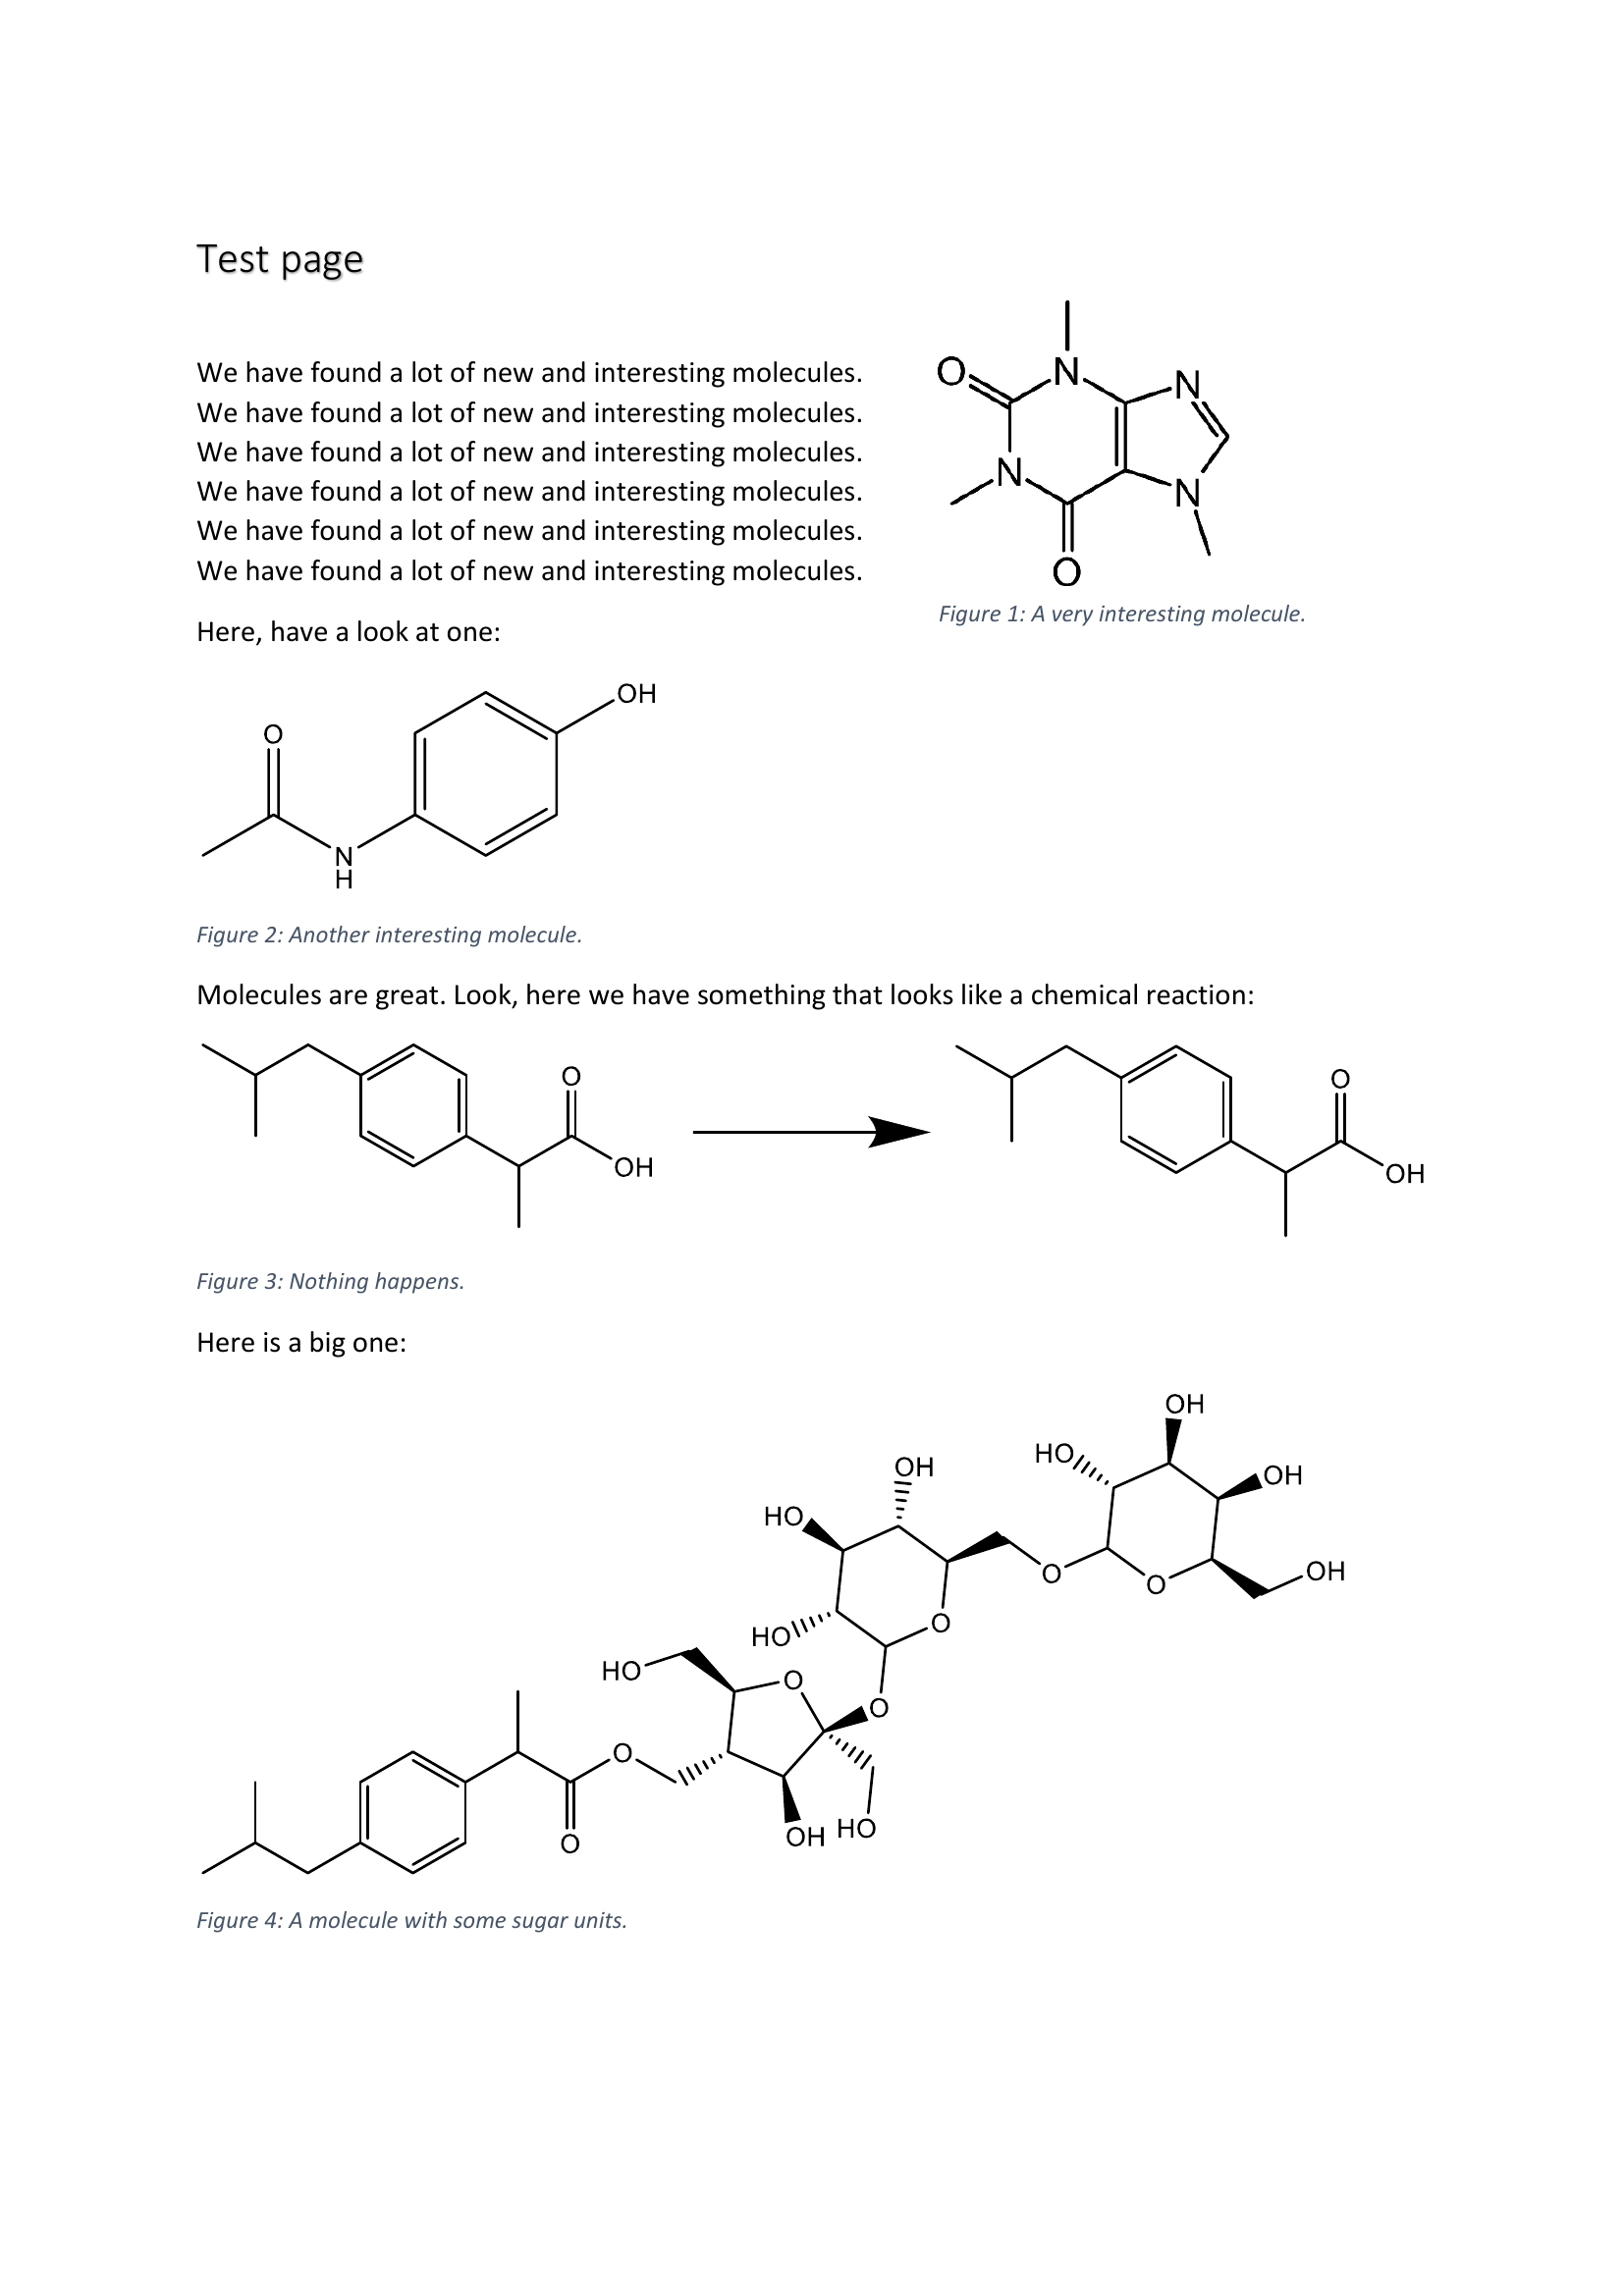

In [50]:
def get_single_pages(filepath: str) -> None:
    """Split the pages of a PDF file into individual .png images.

    Args:
        filepath (str): Absolute or relative path to a .pdf file.

    Returns:
        None

    Example:
        >>> get_single_pages('path/to/example.pdf')

        This will create individual .png images for each page in the 'path/to/example/' directory.
    """
    pages = convert_from_path(filepath, 200)
    display(pages[0]) #Only in this Notebook for demonstration purposes. Change this index to look at different pages.
    for count, page in enumerate(pages):
        output_path = os.path.join(filepath[:-4], f"page_{count}.png")
        page.save(output_path, "PNG")
        
get_single_pages(filepath)

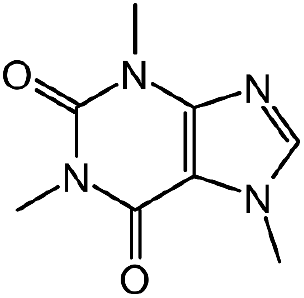

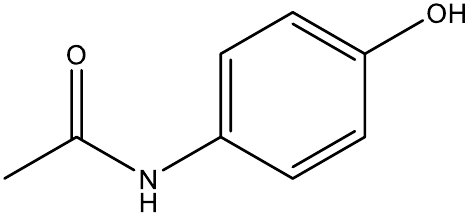

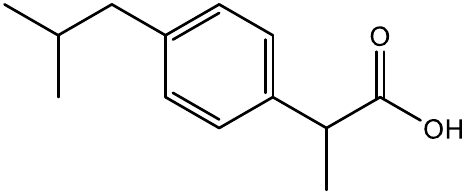

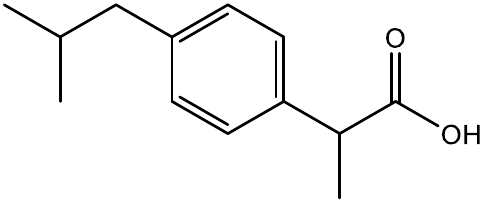

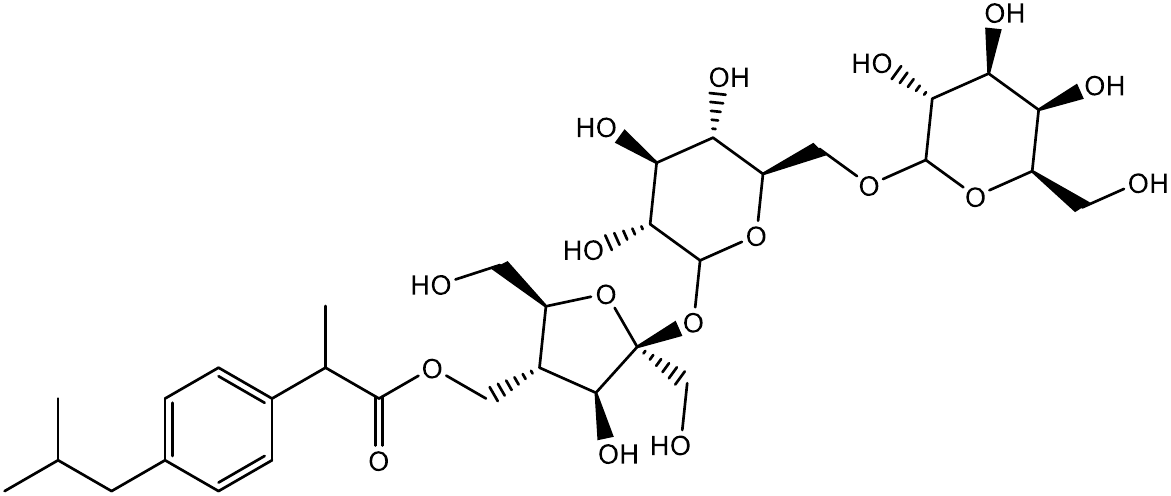

In [51]:
def get_segments(filepath: str) -> None:
    """Run DECIMER segmentation on each page of a PDF and save segmented images.

    This function goes through the created output directory, runs DECIMER segmentation on each page,
    creates a 'segments' directory for each page, and puts the segmented images inside those directories.

    Args:
        filepath (str): Absolute or relative path to a .pdf file.

    Returns:
        None

    Example:
        >>> get_segments('path/to/example.pdf')

        This will create segmented images for each page in the 'path/to/example_segments/' directories.
    """
    directory = filepath[:-4]
    filelist = os.listdir(directory)
    for image in filelist:
        if image.endswith(".png"):
            image_path = os.path.join(directory, image)
            out_dir_path = os.path.join(f"{image_path[:-4]}_segments")
            if not os.path.isdir(out_dir_path):
                os.mkdir(out_dir_path)
            segments = segment_chemical_structures_from_file(
                image_path, expand=True, poppler_path=None
            )
            for segment_index, img_array in enumerate(segments):
                out_img = Image.fromarray(img_array)
                display(out_img) #Only for demsonstration purpose.
                page_path = Path(image_path).stem
                out_img_path = os.path.join(
                    out_dir_path, f"{page_path}_{segment_index}_segmented.png"
                )
                out_img.save(out_img_path, "PNG") 

                
get_segments(filepath)

## DECIMER Image-Transformer

We use DECIMER Image-Transformer (https://github.com/Kohulan/DECIMER-Image_Transformer) to predict a SMILES representation for each segmented structure and calculate an average confidence score for the molecule based on the confidence score for each predicted atom. Currently, this process runs on DECIMER 2.5.0 but will be upgraded to a later release in the future.

In [59]:
def get_smiles_with_avg_confidence(filepath: str) -> None:
    """Predict SMILES and average confidence for segmented images in subdirectories.

    This function takes the path to a PDF file, loops through the affiliated directory with each subdirectory,
    predicts SMILES and an average confidence score for each segmented image.
    It also prints out a predicted image from the SMILES if possible.
    For each segmented image, the SMILES and confidence values will be written to an individual .csv file.

    Args:
        filepath (str): Path to a PDF file with subdirectories containing segmented images.

    Returns:
        None

    Example:
        >>> get_smiles_with_avg_confidence('path/to/example.pdf')

        This will predict SMILES and average confidence for segmented images in subdirectories
        and create .csv files and predicted images for each segmented image.
    """
    dirpath = filepath[:-4]
    for dir_name in [
        d for d in os.listdir(dirpath) if os.path.isdir(os.path.join(dirpath, d))
    ]:
        newdirpath = os.path.join(dirpath, dir_name)
        for im in os.listdir(newdirpath):
            im_path = os.path.join(newdirpath, im)
            if im_path.endswith(".png"):
                smiles_with_confidence = predict_SMILES_with_confidence(im_path)
                smiles_characters = [item[0] for item in smiles_with_confidence]
                smiles = "".join(smiles_characters)
                confidence_list = [item[1] for item in smiles_with_confidence]
                avg_confidence = mean(confidence_list)
                data = [[smiles], [avg_confidence]]
                csv_path = f"{im_path[:-13]}predicted.csv"
                with open(csv_path, "w", encoding="UTF-8") as csvfile:
                    csv_writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
                    csv_writer.writerows(data)
                mol = Chem.MolFromSmiles(smiles, sanitize=False)
                predicted_image_title = os.path.abspath(f"{im_path[:-13]}predicted.png")
                try:
                    Draw.MolToFile(mol, predicted_image_title)
                    #pred_im = Draw.MolToImage(mol, size=(300, 300), kekulize=True)
                    #display(pred_im)
                    print(f'Predicted parsable SMILES and saved predicted image to {predicted_image_title}')
                except ValueError:
                    pass

                
get_smiles_with_avg_confidence(filepath)
# Unfortunately, if there occur SMILES parse errors you need to paste the output from this cell to a 'terminal_output.txt' file that you can access later, so you can extract the errors. If you want to you can uncomment the two code lines and display the predicted image in the output cell. This makes it however more difficult to copy the output, so I recommend running it uncommented first, if you want to look at the images. Then run it again with both lines commented and copy the output from that. This prevents from differences in SMILES prediction and therefore wrong results.  

Predicted parsable SMILES and saved predicted image to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page/page_0_segments/page_0_2_predicted.png
Predicted parsable SMILES and saved predicted image to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page/page_0_segments/page_0_1_predicted.png
Predicted parsable SMILES and saved predicted image to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page/page_0_segments/page_0_2_predicted.png
Predicted parsable SMILES and saved predicted image to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page/page_0_segments/page_0_1_predicted.png
Predicted parsable SMILES and saved predicted image to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page/page_0_segments/page_0_4_predicted.png
Predicted parsable SMILES and saved predicted image to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_

[11:03:37] SMILES Parse Error: unclosed ring for input: 'CCN1C2=C(C(=O)N(C)C1=O)N(C)C=N22'


Predicted parsable SMILES and saved predicted image to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page/page_0_segments/page_0_3_predicted.png
Predicted parsable SMILES and saved predicted image to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page/page_0_segments/page_0_4_predicted.png
Predicted parsable SMILES and saved predicted image to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page/page_0_segments/page_0_3_predicted.png


## Analysis of results

To analyze the results, we utilize a nested dictionary structure for sorting. Each publication's DOI (Digital Object Identifier) serves as a top-level key, with additional keys under each DOI representing paths to segmented chemical structures. The values associated with these structure paths include the corresponding SMILES representation and confidence value. This nested dictionary structure is instrumental in facilitating the creation of a comprehensive CSV file containing all pertinent information.

From this dictionary, we generate a `pd.DataFrame` that forms the basis for creating a CSV file with all relevant data.

To aid in analysis, segmented images are sorted first by page number and then by image number. Python's default sorting method, which prioritizes the first digit of multidigit numbers, necessitates a custom sorting function for accuracy.

Following this, we utilize terminal output to identify SMILES parse errors, which are non-critical and do not disrupt the code flow. These errors are logged in a new column. If no error is detected, the predicted image path is added.

Using this final `pd.DataFrame`, we generate a sorted PDF that displays the predicted SMILES, average confidence value, and segmented image. For valid SMILES predictions, the predicted image is shown alongside the segmented one. In cases of invalid SMILES, the SMILES parse error is displayed on the page.

Upon completion, the input PDF is moved to its respective directory.

In [60]:
def create_output_dictionary(filepath: str, doi: str) -> dict:
    """Create an output dictionary containing SMILES and confidence scores for each segmented image.

    Args:
        filepath (str): Path to a PDF file with subdirectories containing segmented images.
        doi (str): DOI or filename of the PDF file.

    Returns:
        dict: Output dictionary with DOI/Filename as keys and image IDs, SMILES, and confidence scores as values.

    Example:
        >>> create_output_dictionary('path/to/example.pdf', 'example_doi')

    This function traverses through the directory structure created from segmented images stored in CSV files within subdirectories of the provided PDF filepath. It extracts SMILES and confidence scores from these CSV files and organizes them into a dictionary.

    The output dictionary has the following structure:
    {
        'doi': {
            'image_id': ['smiles', 'confidence_score']
        }
    }

    Note:
    - The `filepath` should point to a PDF file with the same name as the provided `doi`, containing subdirectories with CSV files containing SMILES and confidence scores.
    - The `doi` parameter should be unique and can be used as a key in the output dictionary.
    - Each image is uniquely identified by its `image_id`, derived from the filename of the CSV file.
    - SMILES and confidence scores are extracted from the first and second rows of each CSV file, respectively.
    - If multiple images share the same `image_id`, only the last SMILES and confidence score encountered are stored in the output dictionary.

    """
    output_dict = {doi: {}}
    dirpath = filepath[:-4]
    for root, dirs, files in os.walk(dirpath):
        dirs.sort()
        for subdir in dirs:
            newdirpath = os.path.join(root, subdir)
            newdir_list = os.listdir(newdirpath)
            if newdir_list:
                newdir_list.sort()
            for subfiles in newdir_list:
                newfilepath = os.path.join(newdirpath, subfiles)
                if newfilepath.endswith(".csv"):
                    with open(newfilepath, "r", encoding="UTF-8") as csvfile:
                        csv_reader = csv.reader(csvfile)
                        im_dict = {}
                        csv_contents = []
                        for row in csv_reader:
                            csv_contents.append(row)
                        smiles = csv_contents[0]
                        confidence = csv_contents[1]
                        im_id = Path(newfilepath).stem
                        key = im_id[:-10]
                        im_dict[key] = smiles
                        im_dict[key].append(confidence)
                        output_dict[doi].update(im_dict)
    return output_dict
output_dict = create_output_dictionary(filepath,doi)
print(output_dict)

{'test_page': {'page_0_0': ['CCN1C2=C(C(=O)N(C)C1=O)N(C)C=N22', ['0.9969616']], 'page_0_1': ['CC(=O)NC1=CC=C(C=C1)OO', ['0.9633848']], 'page_0_2': ['CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO', ['0.9951932']], 'page_0_3': ['CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO', ['0.9947095']], 'page_0_4': ['CC(C)CC1=CC=C(C=C1)C(C)C(=O)OC[C@@H]2[C@@H](CO)O[C@](CO)([C@H]2O)OC3[C@@H]([C@H]([C@@H]([C@@H](COC4[C@@H]([C@H]([C@H]([C@@H](CO)O4)O)O)O)O3)O)O)OOO', ['0.9906392']]}}


In [61]:
def custom_sort(image_id: str) -> tuple:
    """Custom sorting function for sorting image IDs based on numerical parts.

    Args:
        image_id (str): Image ID in the format 'prefix_num1_num2'.

    Returns:
        tuple: Tuple containing two integers representing the numerical parts of the image ID.

    Example:
        >>> custom_sort('prefix_10_2')
        (10, 2)

    This function is used as a key function for sorting image IDs based on their numerical parts. It extracts the numerical parts from the provided image ID string and returns them as a tuple. The sorting is primarily used to ensure a consistent order of image IDs when creating the output CSV file.
    """
    parts = image_id.split("_")
    return int(parts[1]), int(parts[2])

In [89]:

def create_output_csv(filepath: str, output_dict: dict) -> tuple:
    """Create an output CSV file containing DOI/Filename, image IDs, SMILES, and confidence scores.

    Args:
        filepath (str): Path to the PDF file.
        output_dict (dict): Output dictionary containing SMILES and confidence scores for each segmented image.

    Returns:
        tuple: Tuple containing a pandas DataFrame with the data and the path to the output CSV file.

    Example:
        >>> create_output_csv('path/to/example.pdf', {'example_doi': {'image_id': ['smiles', 'confidence_score']}})

    This function generates an output CSV file containing the extracted SMILES and confidence scores for each segmented image. It utilizes the provided output dictionary to organize the data and writes it to a CSV file.

    The CSV file contains the following columns:
    - DOI/Filename: The DOI or filename of the PDF file.
    - Image ID: Unique identifier for each segmented image.
    - Predicted Smiles: SMILES representation of the predicted chemical structure.
    - Avg Confidence Score: Average confidence score associated with the predicted SMILES.

    Note:
    - The output CSV file is named based on the filename of the provided PDF file and saved in the same directory.
    """
    filename = Path(filepath).stem
    dirpath = Path(filepath).parent
    first_level_keys = list(output_dict.keys())
    data_rows = []
    for first_level_key in first_level_keys:
        second_level_keys = list(output_dict[first_level_key].keys())
        for second_level_key in second_level_keys:
            smiles = output_dict[first_level_key][second_level_key][0]
            confidence_score = output_dict[first_level_key][second_level_key][1][0]
            data_rows.append(
                [first_level_key, second_level_key, smiles, confidence_score]
            )
    df_doi_imid_smiles_conf = pd.DataFrame(
        data_rows,
        columns=[
            "DOI/Filename",
            "Image ID",
            "Predicted Smiles",
            "Avg Confidence Score",
        ],
    )
    df_doi_imid_smiles_conf["sort_key"] = df_doi_imid_smiles_conf["Image ID"].apply(
        custom_sort
    )
    df_doi_imid_smiles_conf = df_doi_imid_smiles_conf.sort_values(by="sort_key").drop(
        columns="sort_key"
    )
    out_csv_path = os.path.join(dirpath, filename, f"{filename}_out.csv")
    df_doi_imid_smiles_conf.to_csv(out_csv_path, index=False)
    return df_doi_imid_smiles_conf, out_csv_path

df_doi_imid_smiles_conf, out_csv_path = create_output_csv(filepath, output_dict)
display(df_doi_imid_smiles_conf)
print(f'The CSV file has been saved to {out_csv_path}')

,DOI/Filename,Image ID,Predicted Smiles,Avg Confidence Score
0,test_page,page_0_0,CCN1C2=C(C(=O)N(C)C1=O)N(C)C=N22,0.9969616
1,test_page,page_0_1,CC(=O)NC1=CC=C(C=C1)OO,0.9633848
2,test_page,page_0_2,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.9951932
3,test_page,page_0_3,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.9947095
4,test_page,page_0_4,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OC[C@@H]2[C@@H](CO...,0.9906392


The CSV file has been saved to /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/test_page/test_page_out.csv


In [90]:

def get_parse_error(output_df, out_csv_path: str, terminal_output: str) -> None:
    """Get parsing errors from RDKit for each SMILES in a merged CSV file (if an error occurs).

    This function reads a merged CSV file containing SMILES predictions and checks for parsing errors
    based on the terminal output. It updates the CSV with a new column 'SMILES Error' containing the error messages.

    Args:
        merged_csv (str): Path to the merged CSV file.
        terminal_output (str): Path to the terminal output file.

    Returns:
        None

    Example:
        >>> get_parse_error('path/to/merged_output.csv', 'path/to/rdkit_terminal_output.txt')

        This will update 'merged_output.csv' with a new column 'SMILES Error' based on parsing errors.
    """
    with open(terminal_output, "r") as file:
        ter_output = file.readlines()
    all_errors = []
    for smiles in output_df["Predicted Smiles"]:
        matching = [s for s in ter_output if smiles in s]
        if matching:
            msg = matching[0]
            word1 = "SMILES"
            word2_options = ("parsing", "input")
            pattern = re.compile(
                f'{re.escape(word1)}(.*?)(?:{ "|".join(map(re.escape, word2_options)) })',
                re.DOTALL,
            )
            match = pattern.search(msg)
            if match:
                error_msg = match.group(0)
        else:
            error_msg = None
        all_errors.append(error_msg)
    output_df["SMILES Error"] = all_errors
    output_df_with_errors = output_df
    output_df_with_errors.to_csv(out_csv_path)
    return output_df_with_errors

terminal_output = '/home/laurin/Hiwi/terminal_output.txt'

output_df_with_errors = get_parse_error(df_doi_imid_smiles_conf,out_csv_path,terminal_output)
display(output_df_with_errors)

,DOI/Filename,Image ID,Predicted Smiles,Avg Confidence Score,SMILES Error
0,test_page,page_0_0,CCN1C2=C(C(=O)N(C)C1=O)N(C)C=N22,0.9969616,SMILES Parse Error: unclosed ring for input
1,test_page,page_0_1,CC(=O)NC1=CC=C(C=C1)OO,0.9633848,None
2,test_page,page_0_2,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.9951932,None
3,test_page,page_0_3,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.9947095,None
4,test_page,page_0_4,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OC[C@@H]2[C@@H](CO...,0.9906392,None


In [91]:
def get_predicted_images(output_df_with_errors: pd.DataFrame, out_csv_path) -> pd.DataFrame:
    """Assign predicted image names for rows with missing values in the output DataFrame.

    Args:
        output_df_with_errors (pd.DataFrame): DataFrame containing rows with missing values.

    Returns:
        pd.DataFrame: DataFrame with predicted image names assigned to rows with missing values.

    This function identifies rows in the input DataFrame where at least one column contains a missing value (NaN). It then generates predicted image names based on the 'Image ID' column and assigns them to the corresponding rows. The predicted image name is constructed by appending '_predicted.png' to the 'Image ID'.

    Note:
    - The input DataFrame should contain the 'Image ID' column.
    - Rows with missing values are identified using the 'isna()' method.
    - Predicted image names are assigned to the 'SMILES Error' column.
    """
    indexes_with_none = output_df_with_errors[
        output_df_with_errors.isna().any(axis=1)
    ].index
    for idx in indexes_with_none:
        im_id = output_df_with_errors.loc[idx, "Image ID"]
        output_df_with_errors.loc[idx, "SMILES Error"] = f"{im_id}_predicted.png"
    output_df_with_errors_and_pred = output_df_with_errors
    output_df_with_errors_and_pred.to_csv(out_csv_path)
    return output_df_with_errors_and_pred

output_df_with_errors_and_pred_im = get_predicted_images(output_df_with_errors, out_csv_path)
display(output_df_with_errors_and_pred_im)

,DOI/Filename,Image ID,Predicted Smiles,Avg Confidence Score,SMILES Error
0,test_page,page_0_0,CCN1C2=C(C(=O)N(C)C1=O)N(C)C=N22,0.9969616,SMILES Parse Error: unclosed ring for input
1,test_page,page_0_1,CC(=O)NC1=CC=C(C=C1)OO,0.9633848,page_0_1_predicted.png
2,test_page,page_0_2,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.9951932,page_0_2_predicted.png
3,test_page,page_0_3,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.9947095,page_0_3_predicted.png
4,test_page,page_0_4,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OC[C@@H]2[C@@H](CO...,0.9906392,page_0_4_predicted.png


In [92]:
def create_pdf(filepath: str, output_df_with_errors_and_pred_im: pd.DataFrame) -> None:
    """Create a PDF containing image names, SMILES, confidence scores, segmented images, and predicted images/SMILES parse errors.

    Args:
        filepath (str): Path to the PDF file.
        output_df_with_errors_and_pred_im (pd.DataFrame): DataFrame containing data for generating the PDF.

    Returns:
        None

    This function generates a PDF containing information about segmented images, predicted SMILES, confidence scores, and corresponding images or SMILES parse errors. Each page of the PDF displays one segmented image along with its predicted SMILES or error message.

    Note:
    - The PDF is created using the FPDF library.
    - Each page of the PDF corresponds to a row in the input DataFrame.
    - The DataFrame should contain columns 'Image ID', 'Predicted Smiles', 'SMILES Error', and 'Avg Confidence Score'.
    """
    dirpath = os.path.splitext(filepath)[0]
    pdf = FPDF(orientation="L")
    pdf.set_font("Arial", size=12)
    for idx, row in output_df_with_errors_and_pred_im.iterrows():
        pagename = row["Image ID"]
        pagesplit = pagename.rsplit("_", 1)
        subdirpath = os.path.join(dirpath, f"{pagesplit[0]}_segments")
        pdf.add_page()
        segmented_image_path = os.path.join(subdirpath, f"{pagename}_segmented.png")
        pdf.cell(0, 10, txt=pagename)
        pdf.image(segmented_image_path, x=10, y=60, w=70)
        pdf.set_x(40)
        pdf.cell(0, 10, txt=row["Predicted Smiles"], ln=True, align="L")
        predicted_image_name = row["SMILES Error"]
        predicted_image_path = os.path.join(subdirpath, predicted_image_name)
        if "SMILES Parse Error" not in predicted_image_path:
            pdf.image(predicted_image_path, x=120, y=60, w=100)
            if row["Avg Confidence Score"]:
                pdf.cell(0, 10, txt=row["Avg Confidence Score"], ln=True)
        else:
            pdf.cell(0, 10, txt=predicted_image_name, ln=True)
            if row["Avg Confidence Score"]:
                pdf.cell(0, 10, txt=row["Avg Confidence Score"], ln=True)
    file_name = os.path.join(dirpath, "output.pdf")
    pdf.output(file_name)
    return file_name
out_pdf_path = create_pdf(filepath,output_df_with_errors_and_pred_im)


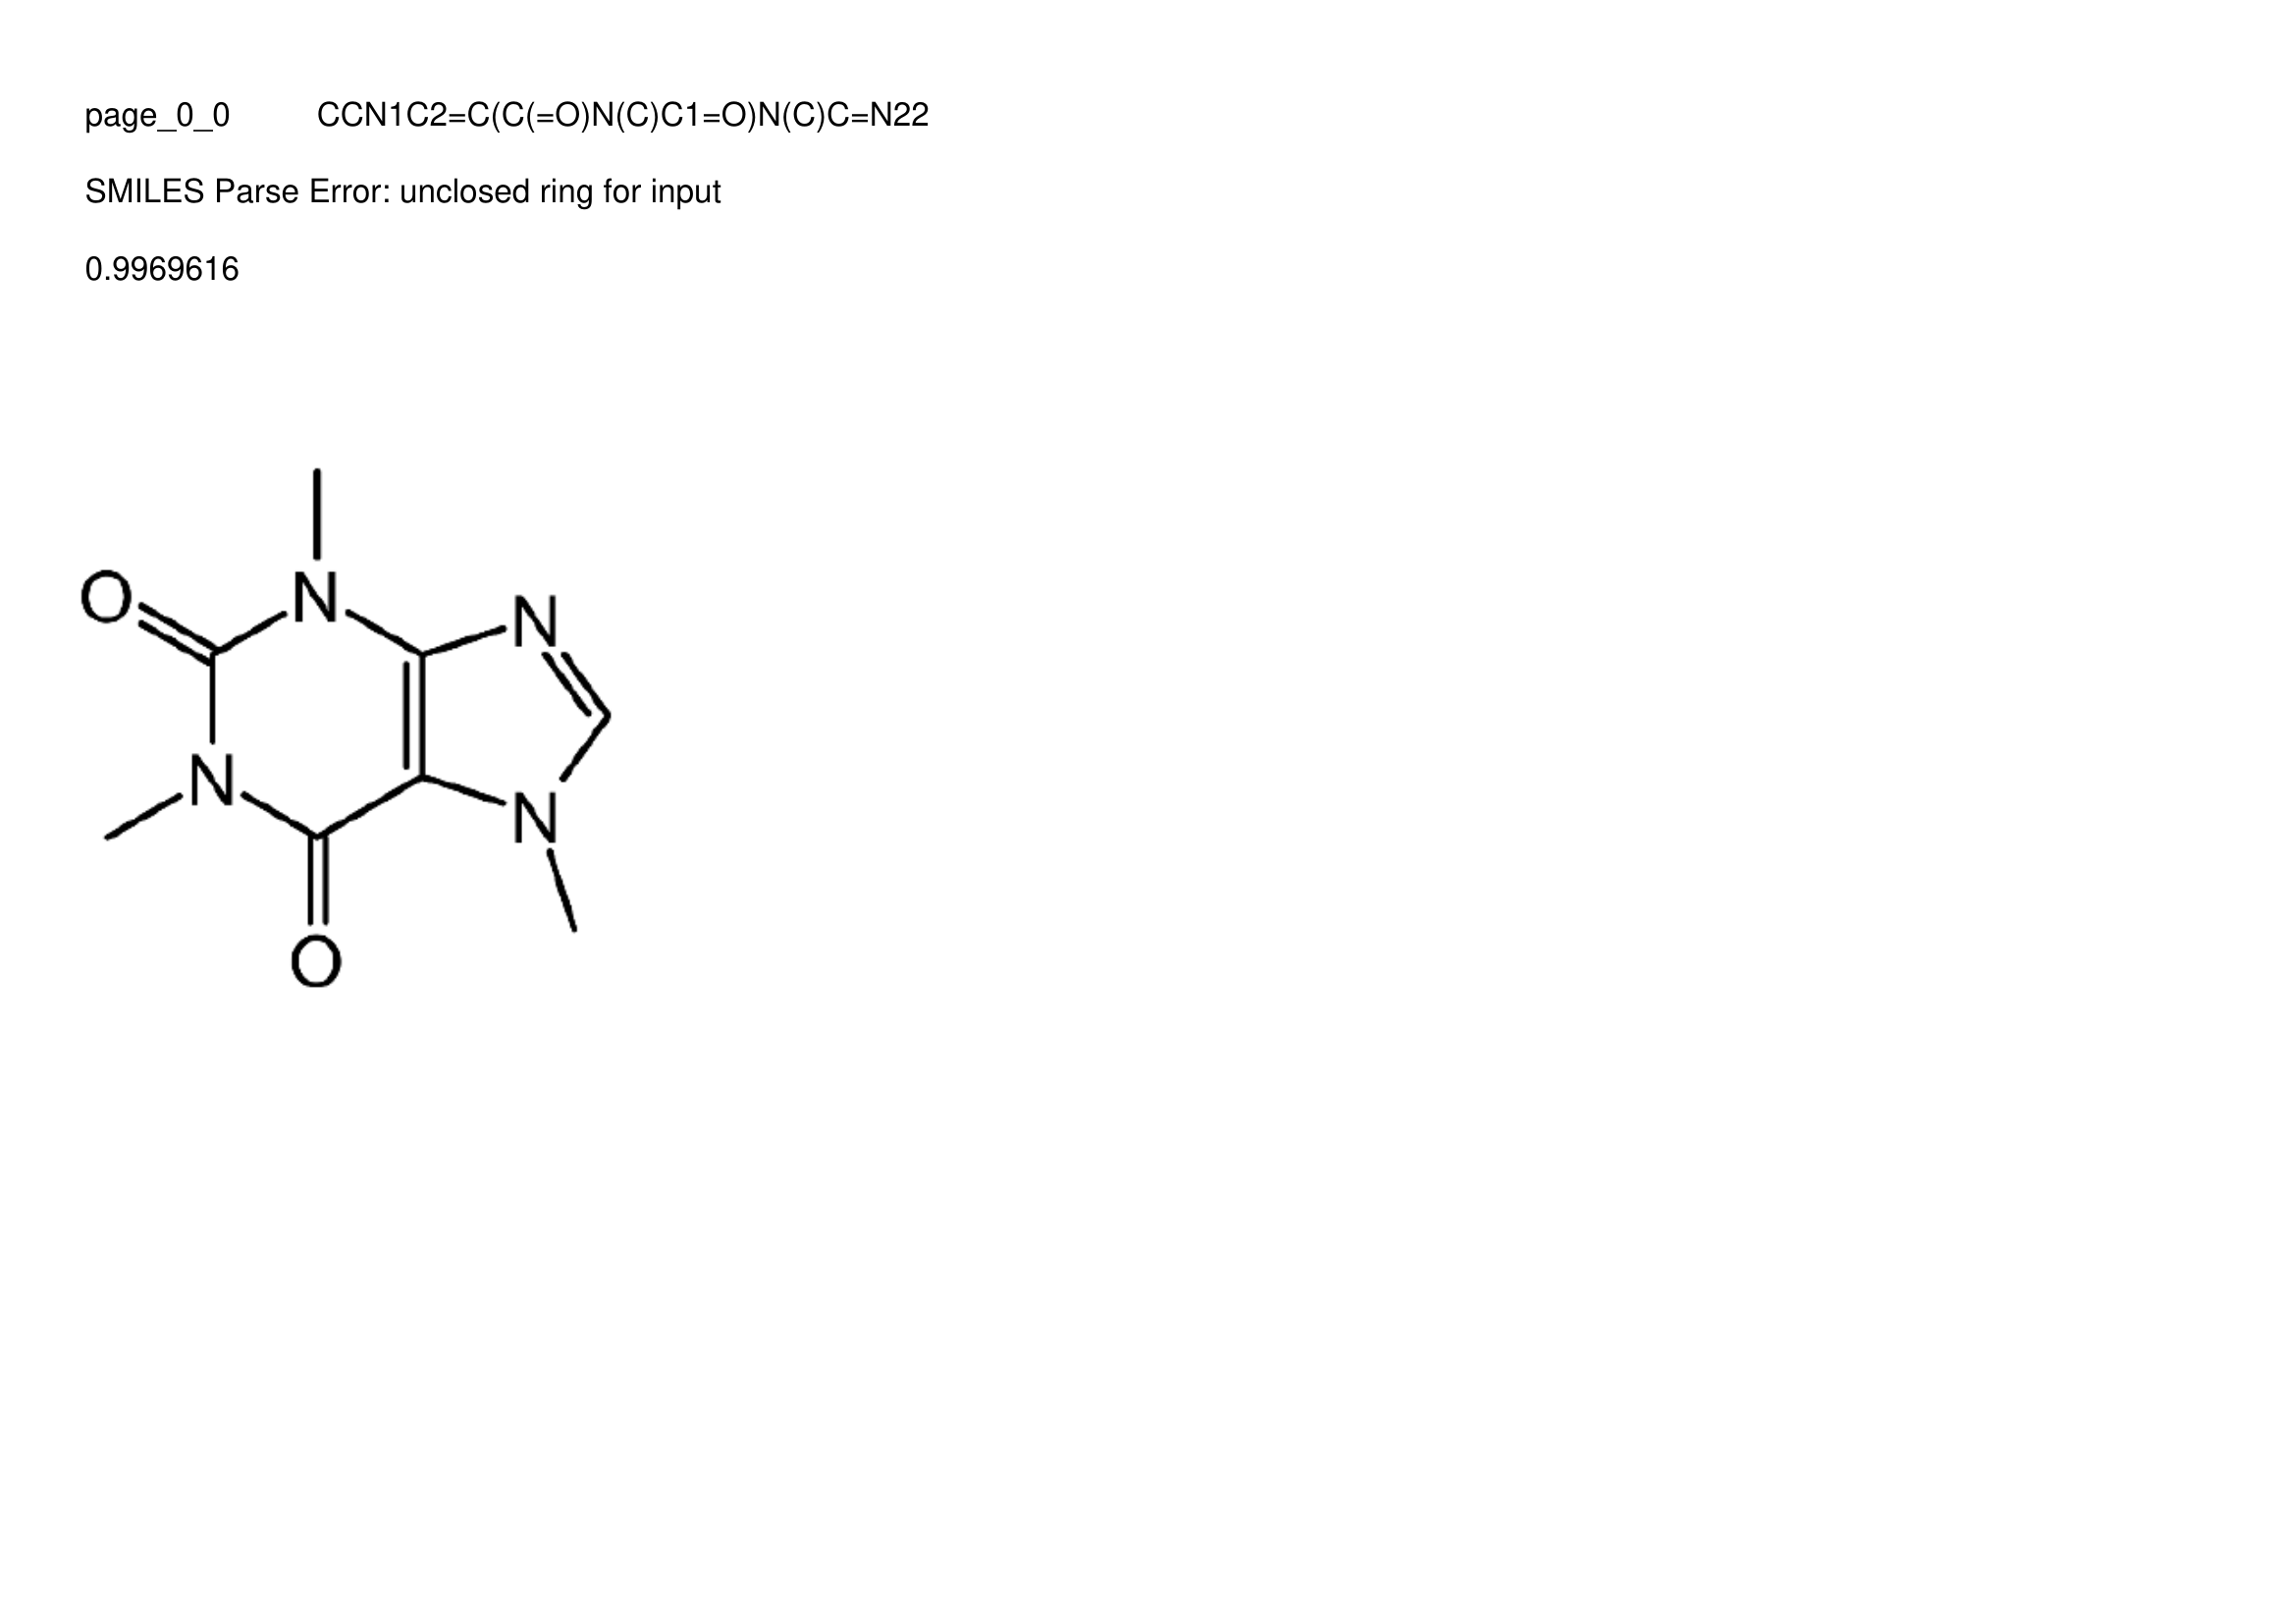

In [93]:
def show_first_out_page(filepath):
    pages = convert_from_path(filepath, 200)
    display(pages[0]) 
    
    
show_first_out_page(out_pdf_path)

## Further processing

To ensure a clean database, only well-predicted structures are included. We have established a threshold of > 0.9 average confidence value to define sufficiently accurate SMILES predictions. Therefore, all publications' CSV files from each batch are concatenated into one CSV file and then split based on their average confidence value.

In this specific case involving a single publication, there is no distinction from the output CSV file of multiple publications. The structures are still categorized based on the accuracy of their SMILES prediction. These categorized files will be saved in the parent directory.

In [94]:
def concatenate_csv_files(
    parent_directory: str, output_file: str = "merged_output.csv"
) -> str:
    """Concatenate CSV files for all publications from subdirectories.

    This function creates a CSV file that is concatenated for all publications from the previously
    concatenated CSV for each publication.

    Args:
        parent_directory (str): Input directory path where the PDFs are. It will also be the output directory
                               where the merged CSV will be saved.
        output_file (str, optional): Name to write the output CSV. Defaults to 'merged_output.csv'.

    Returns:
        str: Filepath of the merged CSV file.

    Example:
        >>> concatenate_csv_files('path/to/pdfs')

        This will concatenate CSV files for all publications from subdirectories and create 'merged_output.csv'.
    """
    subdirectories = [
        d
        for d in os.listdir(parent_directory)
        if os.path.isdir(os.path.join(parent_directory, d))
    ]
    dataframes = []
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(parent_directory, subdirectory)
        csv_files = [f for f in os.listdir(subdirectory_path) if f.endswith(".csv")]
        if csv_files:
            for csv_file in csv_files:
                csv_file_path = os.path.join(subdirectory_path, csv_file)
                df = pd.read_csv(csv_file_path)
                dataframes.append(df)
    merged_data = pd.concat(dataframes)
    merged_data.reset_index(drop=True, inplace=True)
    merged_csv_path = os.path.join(parent_directory, output_file)
    merged_wo_col0 = merged_data.iloc[:, 1:]
    merged_wo_col0.to_csv(merged_csv_path, index=True)
    display(merged_wo_col0)
    return merged_csv_path

merged_csv_path = concatenate_csv_files(parent_path, output_file = "merged_output.csv")
print(f'Created merged CSV file at {merged_csv_path}')


,DOI/Filename,Image ID,Predicted Smiles,Avg Confidence Score,SMILES Error
0,test_page,page_0_0,CCN1C2=C(C(=O)N(C)C1=O)N(C)C=N22,0.996962,SMILES Parse Error: unclosed ring for input
1,test_page,page_0_1,CC(=O)NC1=CC=C(C=C1)OO,0.963385,page_0_1_predicted.png
2,test_page,page_0_2,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.995193,page_0_2_predicted.png
3,test_page,page_0_3,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.994710,page_0_3_predicted.png
4,test_page,page_0_4,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OC[C@@H]2[C@@H](CO...,0.990639,page_0_4_predicted.png


Created merged CSV file at /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/merged_output.csv


In [95]:

def split_good_bad(csv_path: str, value: float = 0.9) -> None:
    """Split a CSV based on confidence scores.

    This function reads a CSV file containing confidence scores and splits it into two CSV files:
    one for confidence scores greater than or equal to a specified value, and one for scores below the value.

    Args:
        csv_path (str): Path to the CSV file containing confidence scores.
        value (float, optional): Threshold value for confidence scores. Defaults to 0.9.

    Returns:
        None

    Example:
        >>> split_good_bad('path/to/confidence_scores.csv', value=0.8)

        This will split the CSV file into two based on confidence scores (good and bad) and create new CSV files.
    """
    merged_file = pd.read_csv(csv_path)
    path = Path(csv_path)
    parent_path = path.parent.absolute()
    df_good = merged_file.loc[merged_file["Avg Confidence Score"] >= value]
    df_bad = merged_file.loc[merged_file["Avg Confidence Score"] < value]
    output_good = os.path.join(parent_path, f"avg_conf_higher_than_{value}.csv")
    output_bad = os.path.join(parent_path, f"avg_conf_lower_than_{value}.csv")
    df_good.to_csv(output_good)
    df_bad.to_csv(output_bad)
    df_good = df_good.style.set_caption('Avg. Confidence score > 0.9')
    display(df_good)
    df_bad = df_bad.style.set_caption('Avg. Confidence score < 0.9')    
    display(df_bad)
    return output_good, output_bad

output_good, output_bad = split_good_bad(merged_csv_path)
print(f"Split all predicted structures, listing well-predicted structures in {output_good} and less accurate structures in {output_bad}.")

,Unnamed: 0,DOI/Filename,Image ID,Predicted Smiles,Avg Confidence Score,SMILES Error
0,0,test_page,page_0_0,CCN1C2=C(C(=O)N(C)C1=O)N(C)C=N22,0.996962,SMILES Parse Error: unclosed ring for input
1,1,test_page,page_0_1,CC(=O)NC1=CC=C(C=C1)OO,0.963385,page_0_1_predicted.png
2,2,test_page,page_0_2,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.995193,page_0_2_predicted.png
3,3,test_page,page_0_3,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OO,0.994710,page_0_3_predicted.png
4,4,test_page,page_0_4,CC(C)CC1=CC=C(C=C1)C(C)C(=O)OC[C@@H]2[C@@H](CO)O[C@](CO)([C@H]2O)OC3[C@@H]([C@H]([C@@H]([C@@H](COC4[C@@H]([C@H]([C@H]([C@@H](CO)O4)O)O)O)O3)O)O)OOO,0.990639,page_0_4_predicted.png


,Unnamed: 0,DOI/Filename,Image ID,Predicted Smiles,Avg Confidence Score,SMILES Error


Split all predicted structures, listing well-predicted structures in /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/avg_conf_higher_than_0.9.csv and less accurate structures in /home/laurin/IWOMI_Tutorials/DECIMER_Extraction/Image_Data_Extraction/avg_conf_lower_than_0.9.csv.
